Task list:
1. cbdDistance - new column to find distance from cbd
2. beachDistance - new column to find distance from nearest beach
3. find school ratings - new columns to replace primary and secondary
4. categorical -> to numerical
5. soldMonth, soldYear
6. latitude and longitude
7. variable selection
- oulier detection

In [1]:
import pandas as pd
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
path = '/Users/tristangarcia/desktop/hp-pred_data/data/wa_data/'

In [3]:
train = pd.read_pickle(f'{path}wa_train_clean.pkl')
test = pd.read_pickle(f'{path}wa_validation_clean.pkl')    # validation set

In [4]:
train.shape

(69355, 39)

In [5]:
train.head()

,listingId,unitNumber,streetNumber,street,suburb,state,postcode,bathrooms,bedrooms,parking,...,suburb_entryLevelPrice,suburb_luxuryLevelPrice,primary,primaryDistance,primaryType,secondary,secondaryDistance,secondaryType,listingUrl,soldPrice
0,2.013763e+09,NaN,7,jubata court,maida vale,wa,6057.0,2,4,2,...,590000.0,1850000.0,maida vale primary school,1016.420520,government,darling range sports college,2218.034622,government,https://www.domain.com.au/7-jubata-court-maida-vale-wa-6057-2013763410,512500.0
1,2.019337e+09,NaN,9,syndicate link,lake coogee,wa,6166.0,2,3,2,...,485000.0,914000.0,coogee primary school,1540.964325,government,divine mercy college,4120.780071,private,https://www.domain.com.au/9-syndicate-link-lake-coogee-wa-6166-2019337055,914000.0
2,2.014115e+09,NaN,107,bulong avenue,redcliffe,wa,6104.0,1,3,1,...,410000.0,830000.0,redcliffe primary school,509.498088,government,alta-1 college - belmont campus,1972.597513,private,https://www.domain.com.au/107-bulong-avenue-redcliffe-wa-6104-2014115350,452000.0
3,2.018923e+09,NaN,24,ferryside road,butler,wa,6036.0,2,4,2,...,510000.0,845000.0,butler primary school,808.852983,government,butler college,1707.715594,government,https://www.domain.com.au/24-ferryside-road-butler-wa-6036-2018923325,600000.0
4,2.019303e+09,NaN,31,lady douglas way,pegs creek,wa,6714.0,1,3,4,...,400000.0,640000.0,pegs creek primary school,779.732155,government,karratha senior high school,1856.050617,government,https://www.domain.com.au/31-lady-douglas-way-pegs-creek-wa-6714-2019302960,525000.0


In [6]:
train.columns

Index(['listingId', 'unitNumber', 'streetNumber', 'street', 'suburb', 'state',
       'postcode', 'bathrooms', 'bedrooms', 'parking', 'landArea', 'latitude',
       'longitude', 'features', 'agency', 'propertyType', 'promoLevel',
       'soldMonth', 'soldYear', 'daysListed', 'inspectionsCount', 'isRural',
       'hasDescription', 'hasFloorplan', 'hasDisplayPrice', 'hasPhoto',
       'photoCount', 'suburb_medianPrice', 'suburb_medianRentPrice',
       'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice', 'primary',
       'primaryDistance', 'primaryType', 'secondary', 'secondaryDistance',
       'secondaryType', 'listingUrl', 'soldPrice'],
      dtype='object')

# Feature transformation

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: ylabel='landArea'>

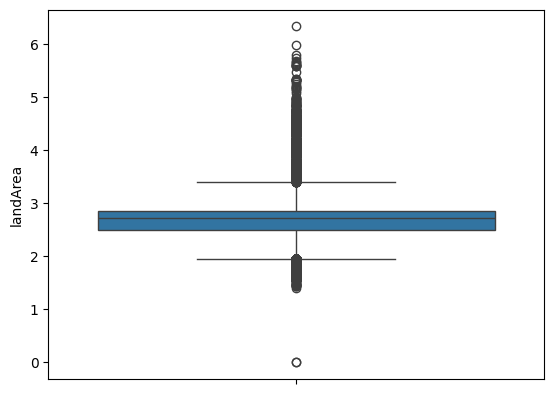

In [7]:
sns.boxplot(np.log10((train['landArea'])))

In [8]:
train['landArea'] = train['landArea'].apply(lambda x: x if x == 0 else np.log10(x))

<Axes: xlabel='landArea', ylabel='Count'>

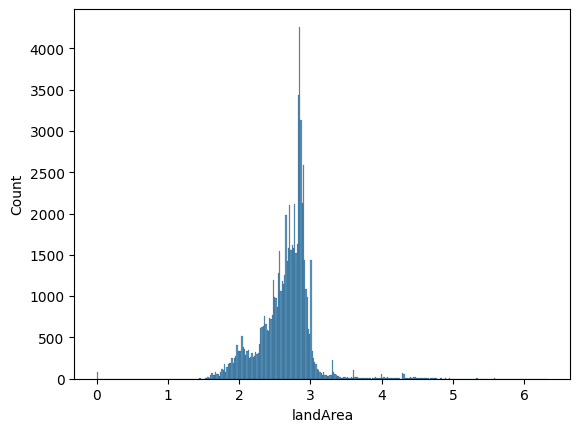

In [9]:
sns.histplot(train['landArea'])

<Axes: xlabel='suburb_medianPrice', ylabel='Count'>

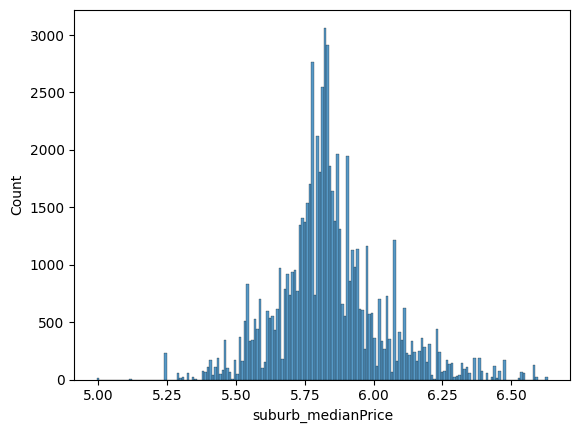

In [10]:
sns.histplot(np.log10(train['suburb_medianPrice']))

<Axes: xlabel='suburb_medianRentPrice', ylabel='Count'>

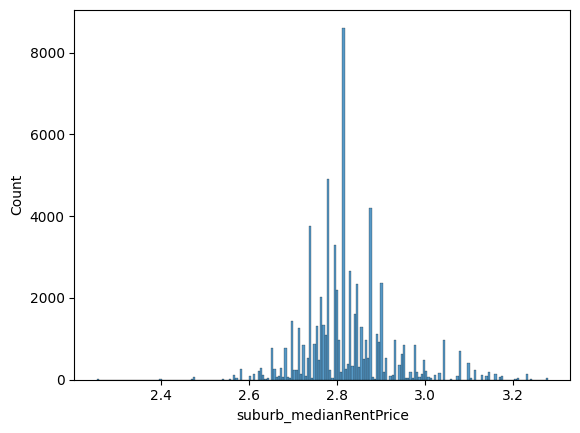

In [11]:
sns.histplot(np.log10(train['suburb_medianRentPrice']))

<Axes: xlabel='suburb_entryLevelPrice', ylabel='Count'>

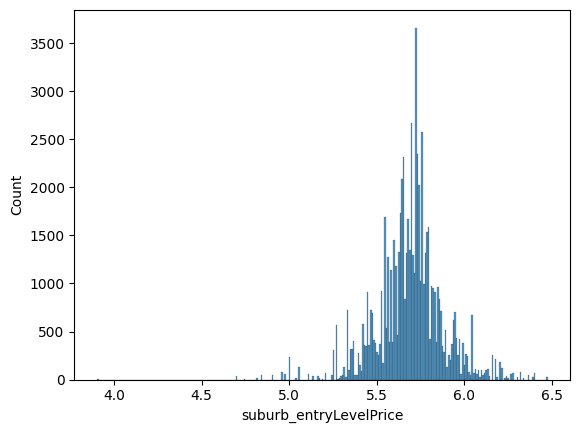

In [12]:
sns.histplot(np.log10(train['suburb_entryLevelPrice']))

<Axes: xlabel='suburb_luxuryLevelPrice', ylabel='Count'>

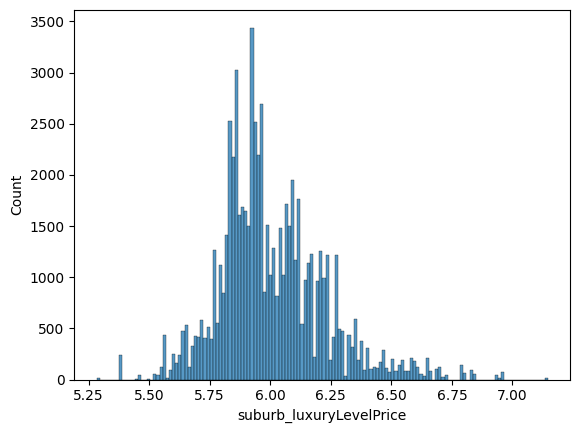

In [13]:
sns.histplot(np.log10(train['suburb_luxuryLevelPrice']))

Applying log10 transformation to the suburb features decreases the shape of the distribution

In [14]:
suburb_features = ['suburb_medianPrice', 'suburb_medianRentPrice',
                   'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice']

for feature in suburb_features:
    train[feature] = train[feature].apply(np.log10)

<Axes: xlabel='primaryDistance', ylabel='Count'>

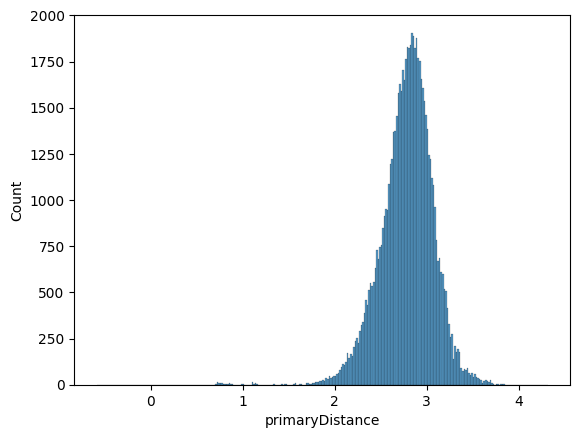

In [15]:
sns.histplot(np.log10(train['primaryDistance']))

<Axes: xlabel='secondaryDistance', ylabel='Count'>

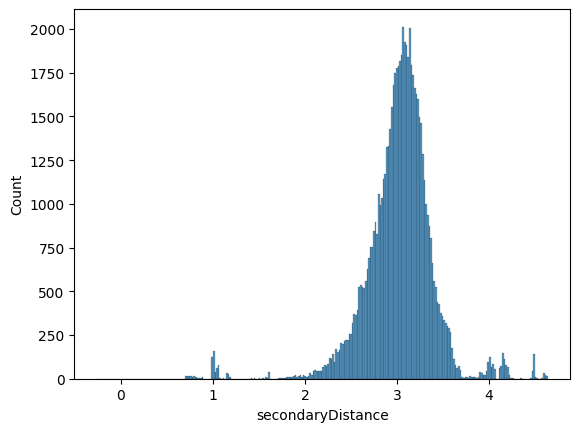

In [16]:
sns.histplot(np.log10(train['secondaryDistance']))

In [17]:
train['primaryDistance'] = train['primaryDistance'].apply(np.log10)
train['secondaryDistance'] = train['secondaryDistance'].apply(np.log10)

# Outlier removal

In [18]:
train['bathrooms'].value_counts()

bathrooms
2     40112
1     25481
3      3228
4       391
5        59
0        50
6        22
8         6
7         4
16        1
17        1
Name: count, dtype: int64

In [19]:
train = train[train['bathrooms'] <= 4]

In [20]:
train['bedrooms'].value_counts()

bedrooms
3     27662
4     25250
2      9864
5      3085
1      2796
6       414
0       107
7        57
8        21
9         3
10        3
Name: count, dtype: int64

In [21]:
train = train[train['bedrooms'] <= 6]

In [22]:
train['parking'].value_counts()

parking
2     38433
1     18885
3      3721
4      3441
0      2982
5       661
6       626
8       160
7       132
10       53
9        34
12       22
11       13
14        6
22        2
21        1
31        1
74        1
20        1
15        1
19        1
16        1
Name: count, dtype: int64

In [23]:
train = train[train['parking'] <= 10]

<Axes: xlabel='landArea', ylabel='Count'>

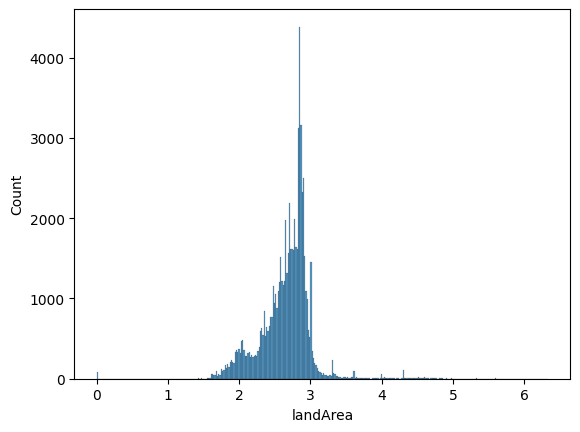

In [24]:
sns.histplot(train['landArea'])

In [25]:
train = train[((train['landArea']>1) & (train['landArea']<4))]

<Axes: xlabel='landArea', ylabel='Count'>

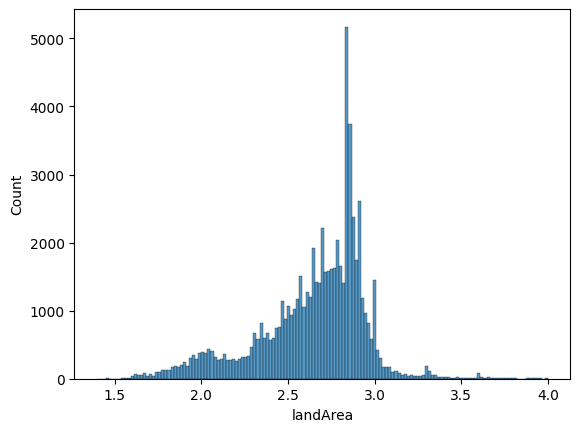

In [26]:
sns.histplot(train['landArea'])

# School ICSEA ratings

In [27]:
school_path = '/Users/tristangarcia/desktop/hp-pred_data/school/'
school_icsea = pd.read_csv(f'{school_path}school_icsea.csv')
school_loc = pd.read_csv(f'{school_path}school_location.csv')

In [28]:
#### Preprocessing school_icsea data ####

# Dropping missing values
school_icsea.dropna(inplace=True)
# Subsetting columns
school_icsea = school_icsea[['School Name', 'Suburb', 'State','School Sector', 'School Type', 'ICSEA']]
# Lowercasing all string values
school_icsea = school_icsea.map(lambda x: x.lower() if isinstance(x,str) else x)
# Changing 'Independent' sector to 'private'
school_icsea['School Sector'] = school_icsea['School Sector'].map(lambda x: 'private' if x=='independent' else x)
# Renaming columns
school_icsea.rename(columns={'School Name':'school','Suburb':'suburb','State':'state',
                        'School Sector':'sector','School Type':'type','ICSEA':'icsea'}, inplace=True)

In [29]:
#### Preprocessing school_loc data ####

# Dropping missing values
school_loc.dropna(inplace=True)
# Subsetting columns
school_loc = school_loc[['School Name', 'Suburb', 'State','School Sector', 'School Type', 'Latitude', 'Longitude']]
# Lowercasing all string values
school_loc = school_loc.map(lambda x: x.lower() if isinstance(x,str) else x)
# Changing 'Independent' sector to 'private'
school_loc['School Sector'] = school_loc['School Sector'].map(lambda x: 'private' if x=='independent' else x)
# Renaming columns
school_loc.rename(columns={'School Name':'school','Suburb':'suburb','State':'state','School Sector':'sector',
                           'School Type':'type','Latitude':'latitude','Longitude':'longitude'}, inplace=True)

In [30]:
school_loc.shape

(10926, 7)

In [31]:
school_icsea.shape

(9565, 6)

In [32]:
# Merging the two dataframes with a left join
school = pd.merge(
    school_loc,  
    school_icsea, 
    on=['school', 'suburb', 'state', 'sector', 'type'], 
    how='left'
)

In [33]:
# Function to find the nearest school and add ICSEA columns
def add_nearest_school_icsea(df, schools, school_type):
    # Filter the schools based on the given school type
    school_df = schools[
        (schools['state'] == 'wa') & 
        ((schools['type'] == school_type) | (schools['type'] == 'combined'))
    ][['school', 'type', 'sector', 'latitude', 'longitude', 'icsea']]
    
    # Initialize Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(school_df[['latitude', 'longitude']])
    
    # Find the nearest school for each house listing
    distances, indices = nn.kneighbors(df[['latitude', 'longitude']])
    
    # Get the ICSEA scores of the nearest schools
    nearest_icsea = school_df.iloc[indices.flatten()]['icsea'].values
    
    # Replace missing ICSEA values with None
    nearest_icsea = [val if not pd.isna(val) else 0 for val in nearest_icsea]
    
    # Add the new ICSEA column to the DataFrame
    df[f'{school_type}ICSEA'] = nearest_icsea
    
    return df

In [34]:
# Adding primaryICSEA and secondaryICSEA to the train dataset
train = add_nearest_school_icsea(train, school, 'primary')
train = add_nearest_school_icsea(train, school, 'secondary')
test = add_nearest_school_icsea(test, school, 'primary')
test = add_nearest_school_icsea(test, school, 'secondary')

In [35]:
train[['primary', 'primaryICSEA','secondary','secondaryICSEA']].head()

,primary,primaryICSEA,secondary,secondaryICSEA
0,maida vale primary school,1021.0,darling range sports college,971.0
1,coogee primary school,1051.0,divine mercy college,1054.0
2,redcliffe primary school,994.0,alta-1 college - belmont campus,0.0
3,butler primary school,976.0,butler college,1014.0
4,pegs creek primary school,870.0,karratha senior high school,916.0


# One Hot Encoding

In [36]:
def ohe_transform(df, transformer, cat_cols):
    '''
    - Performs one hot encoding on selected categorical variables on a df
    - Encoder must be made prior to running this function
    '''
    # Encoding
    transformed = transformer.transform(df)
    # Reformatting OHE column names
    transformer_names = transformer.get_feature_names_out()
    ohe_names = [name.split('__', 1)[-1] for name in transformer_names]
    # Converting back to dataframe
    transformed_df = pd.DataFrame(transformed.toarray(), columns=ohe_names)
    transformed_df.index = df.index
    # Joining OHE df with other numerical features
    df = pd.concat([df, transformed_df], axis=1)
    df = df.drop(columns=cat_cols)
    
    return df

### features

In [37]:
feature_dict = {}

for listing in train['features']:
    for feature in listing:
        if feature in feature_dict.keys():
            feature_dict[feature] += 1
        else:
            feature_dict[feature] = 1

feature_dict = {key: value for key, value in feature_dict.items() if value >= 1500}


In [38]:
dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))

{'air conditioning': 16550,
 'ensuite': 11582,
 'secure parking': 10023,
 'built in wardrobes': 8694,
 'dishwasher': 6355,
 'fully fenced': 6121,
 'close to shops': 5089,
 'close to schools': 4980,
 'close to transport': 4889,
 'built-in wardrobes': 4692,
 'shed': 3827,
 'garden / courtyard': 3673,
 'study': 3312,
 'internal laundry': 2949,
 'balcony / deck': 2843,
 'floorboards': 2779,
 'bath': 2753,
 'garden': 2725,
 'swimming pool': 2674,
 'remote garage': 2397,
 'gas': 2304,
 'solar panels': 2301,
 'alarm system': 2240,
 'heating': 2131,
 'outdoor entertaining': 1817,
 'pets allowed': 1659}

In [39]:
# Filter the features we want to encode based on feature_dict keys
selected_features = list(feature_dict.keys())

# Perform one-hot encoding
for feature in selected_features:
    train[feature] = train['features'].apply(lambda x: 1 if feature in x else 0)
    test[feature] = test['features'].apply(lambda x: 1 if feature in x else 0)

In [40]:
train.columns

Index(['listingId', 'unitNumber', 'streetNumber', 'street', 'suburb', 'state',
       'postcode', 'bathrooms', 'bedrooms', 'parking', 'landArea', 'latitude',
       'longitude', 'features', 'agency', 'propertyType', 'promoLevel',
       'soldMonth', 'soldYear', 'daysListed', 'inspectionsCount', 'isRural',
       'hasDescription', 'hasFloorplan', 'hasDisplayPrice', 'hasPhoto',
       'photoCount', 'suburb_medianPrice', 'suburb_medianRentPrice',
       'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice', 'primary',
       'primaryDistance', 'primaryType', 'secondary', 'secondaryDistance',
       'secondaryType', 'listingUrl', 'soldPrice', 'primaryICSEA',
       'secondaryICSEA', 'air conditioning', 'built-in wardrobes',
       'close to schools', 'close to shops', 'garden', 'secure parking',
       'ensuite', 'built in wardrobes', 'pets allowed', 'bath', 'dishwasher',
       'garden / courtyard', 'close to transport', 'fully fenced', 'shed',
       'floorboards', 'internal laundry', 'hea

In [41]:
# Renaming the encoded columns
column_mapping = {
    'fully fenced': 'feature_fully_fenced',
    'secure parking': 'feature_secure_parking',
    'air conditioning': 'feature_air_conditioning',
    'close to shops': 'feature_close_to_shops',
    'close to schools': 'feature_close_to_schools',
    'built in wardrobes': 'feature_built_in_wardrobes',
    'outdoor entertaining': 'feature_outdoor_entertaining',
    'remote garage': 'feature_remote_garage',
    'heating': 'feature_heating',
    'study': 'feature_study',
    'shed': 'feature_shed',
    'built-in wardrobes': 'feature_built_in_wardrobes',
    'dishwasher': 'feature_dishwasher',
    'floorboards': 'feature_floorboards',
    'internal laundry': 'feature_internal_laundry',
    'pets allowed': 'feature_pets_allowed',
    'bath': 'feature_bath',
    'fireplace(s)': 'feature_fireplace',
    'alarm system': 'feature_alarm_system',
    'balcony / deck': 'feature_balcony',
    'ensuite': 'feature_ensuite',
    'close to transport': 'feature_close_to_transport',
    'formal lounge': 'feature_formal_lounge',
    'garden': 'feature_garden',
    'solar panels': 'feature_solar_panels',
    'gas': 'feature_gas',
    'garden / courtyard': 'feature_courtyard',
    'broadband internet access': 'feature_broadband_internet',
    'swimming pool': 'feature_swimming_pool'
}

# Apply the renaming
train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)

In [42]:
train.columns

Index(['listingId', 'unitNumber', 'streetNumber', 'street', 'suburb', 'state',
       'postcode', 'bathrooms', 'bedrooms', 'parking', 'landArea', 'latitude',
       'longitude', 'features', 'agency', 'propertyType', 'promoLevel',
       'soldMonth', 'soldYear', 'daysListed', 'inspectionsCount', 'isRural',
       'hasDescription', 'hasFloorplan', 'hasDisplayPrice', 'hasPhoto',
       'photoCount', 'suburb_medianPrice', 'suburb_medianRentPrice',
       'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice', 'primary',
       'primaryDistance', 'primaryType', 'secondary', 'secondaryDistance',
       'secondaryType', 'listingUrl', 'soldPrice', 'primaryICSEA',
       'secondaryICSEA', 'feature_air_conditioning',
       'feature_built_in_wardrobes', 'feature_close_to_schools',
       'feature_close_to_shops', 'feature_garden', 'feature_secure_parking',
       'feature_ensuite', 'feature_built_in_wardrobes', 'feature_pets_allowed',
       'feature_bath', 'feature_dishwasher', 'feature_courtyard'

### propertyType, promoLevel

In [43]:
cat_cols = ['propertyType','promoLevel']
# Create encoder handle_unknown ensures that unseen values in the test set are ignored
t = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), 
                                      ['propertyType','promoLevel','primaryType','secondaryType']))
t.fit(train)

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['propertyType', 'promoLevel', 'primaryType',
                                  'secondaryType'])])

In [44]:
test.columns

Index(['listingId', 'unitNumber', 'streetNumber', 'street', 'suburb', 'state',
       'postcode', 'bathrooms', 'bedrooms', 'parking', 'landArea', 'latitude',
       'longitude', 'features', 'agency', 'propertyType', 'promoLevel',
       'soldMonth', 'soldYear', 'daysListed', 'inspectionsCount', 'isRural',
       'hasDescription', 'hasFloorplan', 'hasDisplayPrice', 'hasPhoto',
       'photoCount', 'suburb_medianPrice', 'suburb_medianRentPrice',
       'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice', 'primary',
       'primaryDistance', 'primaryType', 'secondary', 'secondaryDistance',
       'secondaryType', 'listingUrl', 'soldPrice', 'primaryICSEA',
       'secondaryICSEA', 'feature_air_conditioning',
       'feature_built_in_wardrobes', 'feature_close_to_schools',
       'feature_close_to_shops', 'feature_garden', 'feature_secure_parking',
       'feature_ensuite', 'feature_built_in_wardrobes', 'feature_pets_allowed',
       'feature_bath', 'feature_dishwasher', 'feature_courtyard'

In [45]:
train = ohe_transform(train,t,cat_cols)
test = ohe_transform(test,t,cat_cols)

In [46]:
train.columns

Index(['listingId', 'unitNumber', 'streetNumber', 'street', 'suburb', 'state',
       'postcode', 'bathrooms', 'bedrooms', 'parking', 'landArea', 'latitude',
       'longitude', 'features', 'agency', 'soldMonth', 'soldYear',
       'daysListed', 'inspectionsCount', 'isRural', 'hasDescription',
       'hasFloorplan', 'hasDisplayPrice', 'hasPhoto', 'photoCount',
       'suburb_medianPrice', 'suburb_medianRentPrice',
       'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice', 'primary',
       'primaryDistance', 'primaryType', 'secondary', 'secondaryDistance',
       'secondaryType', 'listingUrl', 'soldPrice', 'primaryICSEA',
       'secondaryICSEA', 'feature_air_conditioning',
       'feature_built_in_wardrobes', 'feature_close_to_schools',
       'feature_close_to_shops', 'feature_garden', 'feature_secure_parking',
       'feature_ensuite', 'feature_built_in_wardrobes', 'feature_pets_allowed',
       'feature_bath', 'feature_dishwasher', 'feature_courtyard',
       'feature_close_to_tra

# Binarization

In [47]:
binary_cols = ['isRural','hasDescription', 'hasFloorplan', 'hasDisplayPrice', 'hasPhoto']

# Binarizing all columns
for col in binary_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

# Constant features
Removing features with vary small variance. These features don't provide any additional advantage to machine learning models

In [48]:
# Select only numeric columns
numeric_train = train.select_dtypes(include=["number"])
numeric_test = test.select_dtypes(include=["number"])

In [49]:
# Apply VarianceThreshold to numeric columns
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(numeric_train)  # Fit only on numeric columns

# Get the remaining features
features_to_keep = numeric_train.columns[sel.get_support()]
features_removed = numeric_train.columns[~sel.get_support()]  # Features not selected

In [50]:
# Transform the numeric data
numeric_train = sel.transform(numeric_train)
numeric_test = sel.transform(numeric_test)

In [51]:
# Transform the arrays back to DataFrames
numeric_train = pd.DataFrame(numeric_train, columns=features_to_keep)
numeric_test = pd.DataFrame(numeric_test, columns=features_to_keep)

In [52]:
# Combine back with non-numeric columns
train = pd.concat([train.select_dtypes(exclude=["number"]), numeric_train], axis=1)
test = pd.concat([test.select_dtypes(exclude=["number"]), numeric_test], axis=1)

train.shape, test.shape

((69346, 73), (17358, 73))

In [53]:
features_removed

Index(['inspectionsCount', 'isRural', 'hasDescription', 'hasDisplayPrice',
       'hasPhoto', 'suburb_medianRentPrice', 'promoLevel_elite_pp'],
      dtype='object')

# Irrelevant features

In [54]:
# Dropping the irrelevant columns
train = train.drop(columns=['listingId', 'unitNumber', 'streetNumber', 'street', 'state',
                          'postcode', 'agency', 'suburb','features', 'propertyType', 'promoLevel', 
                          'primary', 'secondary', 'listingUrl'], errors='ignore')

test = test.drop(columns=['listingId', 'unitNumber', 'streetNumber', 'street', 'state',
                          'postcode', 'agency', 'suburb','features', 'propertyType', 'promoLevel', 
                          'primary', 'secondary', 'listingUrl'], errors='ignore')



# Removing the rest of the missing values
Some null values still remain even after imputation as there isn't enough information to impute on other values

In [55]:
train.dropna(inplace=True)
test.dropna(inplace=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(train.shape)
print(test.shape)

(67636, 61)
(17340, 61)


# Geospatial features

### coastDistance 
For each property listing, find the distance to the nearest coastline

In [56]:
# https://www.naturalearthdata.com/downloads/10m-physical-vectors/
# Load coastline data 
coastline = gpd.read_file("/Users/tristangarcia/desktop/hp-pred_data/ne_50m_coastline/ne_50m_coastline.shp")
# Reproject coastline to EPSG:3395 (meters)
coastline = coastline.to_crs(epsg=3395)

In [57]:
def convert_to_gdf(df):
    # Convert df to GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    # Reproject train data to EPSG:3395 (meters)
    gdf = gdf.to_crs(epsg=3395)
    
    return df

In [58]:
def get_coastDistance(gdf,df):
    # Calculate distances to the nearest coastline
    gdf['coastDistance'] = gdf.geometry.apply(
        lambda point: coastline.distance(point).min()
    )

    # Assigning a new variable to the original df
    df['coastDistance'] = gdf['coastDistance']
    # Removing helper column
    df.drop(columns=['geometry'], inplace=True)
    
    return df

In [59]:
# Converting train and test sets to geodataframes
train_gdf = convert_to_gdf(train)
test_gdf = convert_to_gdf(test)

In [60]:
# Creating new coastDistance variable
train = get_coastDistance(train_gdf,train)
test = get_coastDistance(test_gdf,test)

In [61]:
# Check results
print(train[['latitude', 'longitude', 'coastDistance']].head())

    latitude   longitude  coastDistance
0 -31.957170  116.018388  572456.668046
1 -32.136424  115.783409  572456.741625
2 -31.930981  115.947431  572456.616289
3 -31.641348  115.695776  572456.251512
4 -20.734956  116.838286  572446.651362


### cbdDistance
For each property listing, find the distance to Perth CBD

In [62]:
# CBD coordinates
perth_cbd_lat = 31.9514
perth_cbd_lon = 115.8617  

# Create a GeoDataFrame for the CBD point
perth_cbd = gpd.GeoDataFrame(
    geometry=[Point(perth_cbd_lon, perth_cbd_lat)],
    crs="EPSG:4326"
).to_crs(epsg=3395)  # Reproject to EPSG:3395 (meters)

In [63]:
def get_cbdDistance(gdf,df):
    # Calculate distance to Perth CBD in meters
    gdf['cbdDistance'] = gdf.geometry.apply(
        lambda point: perth_cbd.distance(point).min()
    )

    # Assigning a new variable to the original df
    df['cbdDistance'] = gdf['cbdDistance']
    # Removing helper column
    df.drop(columns=['geometry'], inplace=True)
    
    return df

In [64]:
# Converting train and test sets to geodataframes
train_gdf = convert_to_gdf(train)
test_gdf = convert_to_gdf(test)

In [65]:
# Creating new cbdDistance variable
train = get_cbdDistance(train_gdf,train)
test = get_cbdDistance(test_gdf,test)

In [66]:
# Check results
print(train[['latitude', 'longitude', 'cbdDistance']].head())

    latitude   longitude   cbdDistance
0 -31.957170  116.018388  1.342729e+07
1 -32.136424  115.783409  1.342729e+07
2 -31.930981  115.947431  1.342729e+07
3 -31.641348  115.695776  1.342729e+07
4 -20.734956  116.838286  1.342729e+07


### Spatial region clustering

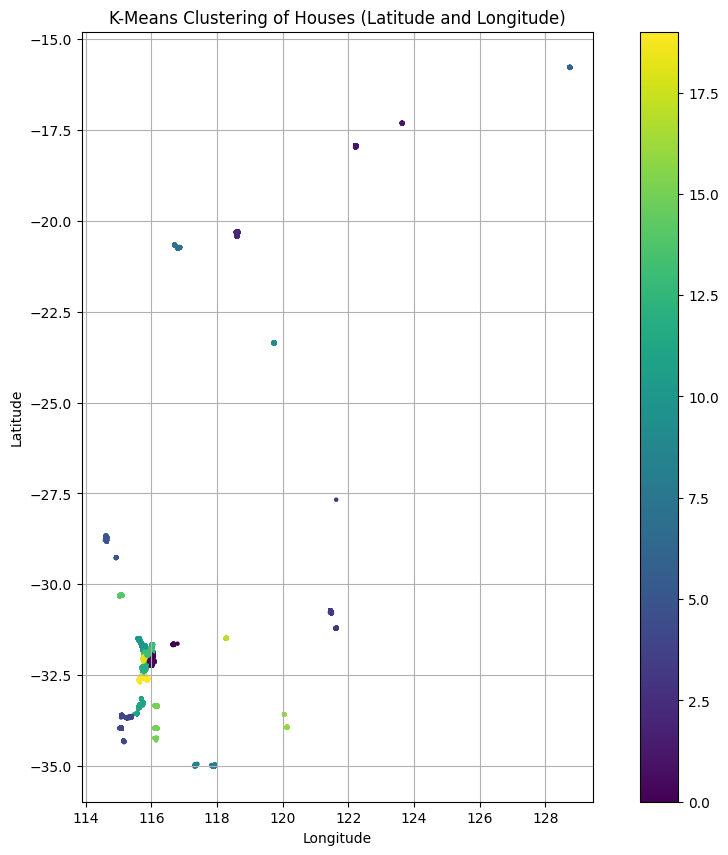

In [67]:
# Create geometry column with shapely Points
train['geometry'] = train.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(train, geometry='geometry', crs="EPSG:4326")  # WGS84 CRS

# Extract latitude and longitude as input for clustering
coords = train[['latitude', 'longitude']]
# Fit K-Means
km = KMeans(n_clusters=20)
km.fit(coords)
train['cluster_id'] = km.predict(coords)
test['cluster_id'] = km.predict(test[['latitude','longitude']])

# Add cluster_id to GeoDataFrame
gdf['cluster_id'] = train['cluster_id']

# Visualize clusters using GeoPandas
# Plot clusters with a unique color for each cluster
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(column='cluster_id', cmap='viridis', legend=True, ax=ax, markersize=5)
plt.title('K-Means Clustering of Houses (Latitude and Longitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [68]:
train['cluster_id'].value_counts()

cluster_id
13    23241
18     9862
0      9066
10     7248
12     5088
19     2513
11     2150
4      1677
3      1208
2      1121
1       958
15      879
7       710
5       689
8       516
14      278
9       204
6       101
16       65
17       62
Name: count, dtype: int64

# Standardisation

In [69]:
std_features = ['bathrooms', 'bedrooms', 'parking', 'landArea','daysListed','photoCount', 'suburb_medianPrice',
                'suburb_entryLevelPrice','suburb_luxuryLevelPrice','primaryDistance','secondaryDistance',
                'coastDistance', 'cbdDistance', 'primaryICSEA','secondaryICSEA']
scaler = StandardScaler()
scaler.fit(train[std_features])

StandardScaler()

In [70]:
train[std_features] = scaler.transform(train[std_features])
test[std_features] = scaler.transform(test[std_features])

# Duplicates removal

In [71]:
# Number of duplicates in training set
print(len(train) - len(train.loc[train.drop_duplicates().index]))
train = train.drop_duplicates()
# Number of duplicates in validation set
print(len(test) - len(test.loc[test.drop_duplicates().index]))
test = test.drop_duplicates()

6
0


In [72]:
train.shape

(67630, 65)

In [73]:
test.shape

(17340, 64)

In [74]:
len(train)/(len(train)+len(test))

0.7959279745792632